In [8]:
%matplotlib inline

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

!pip install varname
import varname
import os
import time
import math
import pickle
import datetime

In [10]:
#this stuff was added to invidual classses and functions that needed it

#activity labels as defined in activity_labels.txt
#activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']
#activity_labels = {k:v for k,v in enumerate(activity_labels, start=1)}
#print(activity_labels)

In [11]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    google = True
    colab_folder = '/content/gdrive/My Drive/Colab Notebooks/ecps205_final_project/'
except:
    colab_folder=''

In [12]:
#load data
def load_data(path):
    data = pd.read_csv(path, header=None, delim_whitespace=True)
    return data.values

def load_set(path, x, y):
    data = load_data(path+x)
    labels = load_data(path+y)
    return data, labels

#reduce the labels by 1 to match with the activity_labels and also to start labels at 0 to 11 instead of from 1 to 12
def adjust_labels (labels):
    for i in range(len(labels)):
        labels[i][0] -= 1
    return labels

train_data, train_labels = load_set(colab_folder + 'HAPT Data Set/Train/', 'X_train.txt', 'y_train.txt')
test_data, test_labels = load_set(colab_folder + 'HAPT Data Set/Test/', 'X_test.txt', 'y_test.txt')

print('reshaping data...')
#reshape the data to add a features dimension (features = 1)
#https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d
train_data = np.expand_dims(train_data, axis=2)
test_data = np.expand_dims(test_data, axis=2)

print('adjusting labels...')
#print(train_labels)
#print(test_labels)
train_labels = adjust_labels(train_labels);
test_labels = adjust_labels(test_labels);
#print(train_labels)
#print(test_labels)

reshaping data...
adjusting labels...


In [13]:
#takes an array of data as an input
class PlotData():
    activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']
    def __init__(self, data, labels, name):
        self.data = data
        self.labels = labels
        self.name = name
        
    #start = starting index (inclusive) for data to create plots for
    #end = ending index (exclusive) for data to create plots for
    #index starts at zero but when looking at the .txt files, index starts at 1, take that into account when choosing data points to plot
    def plot_data(self, start, end='', save=False):
        if end == '':
            r = 1 #range of data
        else:
            r = end-start #range of data
        if r == 1 or end == '':
            fig, ax = plt.subplots(r ,figsize=(20,5))
            ax.plot(self.data[start])
            ax.grid()
            ax.set(xlabel='Timestep', ylabel='Processed Data', title=f'{self.activity_labels[self.labels[start][0]]} (label: {self.labels[start][0]+1}) (row: {start})')
        else:
            for i in range(r):
                fig, ax = plt.subplots(r ,figsize=(20,5*(r)))
                d_i = i+start
                ax[i].plot(self.data[d_i])
                ax[i].grid()
                ax[i].set(xlabel='Timestep', ylabel='Processed Data', title=f'{self.activity_labels[self.labels[d_i][0]]} (label: {self.labels[d_i][0]+1}) (row: {d_i})')
        fig.subplots_adjust(hspace=1)
        if save:
            plt.savefig(colab_folder + f"plots/train_test/{self.name}_{start}-{end}.png")
        plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'plots/train_test/train_data_88-.png'

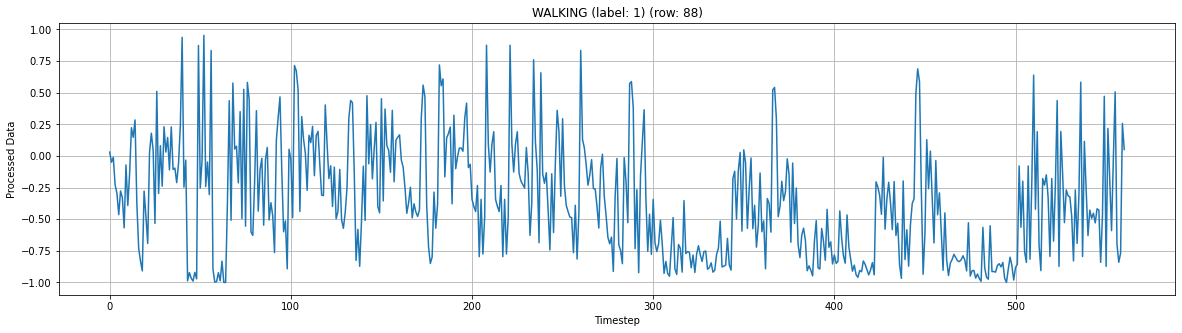

In [14]:
p_train = PlotData(train_data, train_labels, varname.nameof(train_data))
p_train.plot_data(88, save=True)
p_train.plot_data(162, save=True)
p_train.plot_data(152, save=True)
p_train.plot_data(204, save=True)
p_train.plot_data(194, save=True)
p_train.plot_data(234, save=True)
p_train.plot_data(200, save=True)
p_train.plot_data(923, save=True)
p_train.plot_data(2245, save=True)
p_train.plot_data(2230, save=True)
p_train.plot_data(2567, save=True)
p_train.plot_data(2260, save=True)
#p_test = PlotData(test_data, test_labels)
#p_test.plot_data(500)

In [8]:
#get time of epochs to record training time
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [9]:
#print out n number (pred_range) of predicted values and compare them with test labels
def predict(pred_range, pred_outs, test_labels):
    activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']

    #test if the label matches the prediction
    false_pred = 0
    true_pred = 0
    #look at predictions for the first 25 values
    for i in range(pred_range):
        if not (0 <= pred_outs[i] or pred_outs[i] <= 11):
            print('prediction out of bounds')
            break

        print(f'Test label: {activity_labels[test_labels[i][0]]}')
        print(f'Predicted label:{activity_labels[pred_outs[i]]}')

        if pred_outs[i]==test_labels[i][0]:
            print('true\n')
            true_pred += 1
        else:
            print('false\n')
            false_pred += 1
    print(f'False predictions:{false_pred}')
    print(f'True predictions:{true_pred}')
    print(f'Prediction accuraccy for first {pred_range} values: {true_pred/pred_range}')

In [10]:
def run_model(test_data, test_labels, train_data, train_labels, filters, kernel_size, dropout, dense, epochs, it='', show_predict=True, save_model=False):
    save_path = f'filters-{filters}_kernel_size-{kernel_size}_dropout-{dropout}_dense-{dense}_epochs-{epochs}_it-{it}'
    saved_model_path = f'{colab_folder}saved_models\\{save_path}'
    current_directory = os.path.abspath(os.getcwd())
    training_time=-1   #denotes pre-trained model being loaded from saved models
    history=-1 #denotes pre-trained model being loaded from saved models
    
    if os.path.exists(os.path.join(current_directory,saved_model_path)) :
        print(f'found saved model, loading from: {saved_model_path}')
        model = models.load_model(saved_model_path)
        test_loss,test_acc = model.evaluate( test_data, test_labels, verbose=2)
    else:
        #input shape
        timesteps = train_data.shape[1] #561 timesteps
        features = train_data.shape[2] #1 feature

        #model
        model = models.Sequential()
        model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, activation='relu', input_shape=(timesteps,features)))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(dropout))
        model.add(layers.Flatten())
        model.add(layers.Dense(dense, activation='relu'))
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(12, activation='relu'))
        model.summary()

        # Compile the model
        model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
        #evaluate model
        test_loss,test_acc = model.evaluate(test_data, test_labels, verbose=2)

        if show_predict:
            #predict
            pred_outs = model.predict_classes(test_data)
            #display predictions
            predict(10, pred_outs, test_labels)

        #train the model
        #set up timing callback
        time_callback = TimeHistory()

        history = model.fit(train_data, 
                  train_labels, 
                  epochs=epochs, 
                  validation_data=(test_data, test_labels),
                callbacks=[time_callback])

        test_loss,test_acc = model.evaluate( test_data, test_labels, verbose=2)

        training_time = sum(time_callback.times)
        
        if save_model:
            model.save(saved_model_path)
        
        history = history.history
    return test_loss, test_acc, training_time, history

In [11]:
#run_model(test_data, test_labels, train_data, train_labels, filters=32, kernel_size=3, dropout=0.5, dense=128, epochs=3, it='', show_predict=False, save_model=False)

In [12]:
def time_unit_string(time):
    return f"Total training time: {math.floor(time/1)}s {math.floor(time%1 * 1000)}ms {math.ceil(time%(1/1000)*1000)}us"

class RunTests: 
    #init the default model parameters
    #n_tests is the number of tests to run for each parameter
    def __init__(self, n_tests, d_filters, d_kernel_size, d_dropout, d_dense, d_epochs):
        self.n_tests = n_tests
        self.d_filters = d_filters
        self.d_kernel_size = d_kernel_size
        self.d_dropout = d_dropout
        self.d_epochs = d_epochs
        self.d_dense = d_dense    
        
    #tests a specific parameter n_tests number of times
    #the parameter should be specified as a list, see examples below
    #!!only choose one parameter at a time!!
    def test_param(self, filters=None, kernel_size=None, dropout=None, dense=None, epochs=None, save=True):    
        if isinstance(filters,list):
            data = filters
            data_type = 'filters'
            kernel_size = self.d_kernel_size
            dropout=self.d_dropout
            epochs=self.d_epochs
            dense=self.d_dense
        elif isinstance(kernel_size,list):
            data = kernel_size
            data_type = 'kernel_size'
            dropout=self.d_dropout
            epochs=self.d_epochs
            filters = self.d_filters
            dense=self.d_dense
        elif isinstance(dropout,list):
            data = dropout
            data_type = 'dropout'
            kernel_size = self.d_kernel_size
            epochs=self.d_epochs
            filters = self.d_filters
            dense=self.d_dense
        elif isinstance(dense, list):
            data=dense
            data_type='dense'
            kernel_size = self.d_kernel_size
            dropout=self.d_dropout
            epochs=self.d_epochs
            filters = self.d_filters
        elif isinstance(epochs,list):
            data = epochs
            data_type = 'epochs'
            kernel_size = self.d_kernel_size
            dropout=self.d_dropout
            filters = self.d_filters
            dense=self.d_dense
        else:
            print('no data type selected, running default...')
            data = [1]
            data_type = 'default'
            kernel_size = self.d_kernel_size
            dropout=self.d_dropout
            epochs=self.d_epochs
            filters = self.d_filters
            dense=self.d_dense
            
        model_test_data = []
        for index, item in enumerate(data):
            model_test_data.append([])
            for i in range(0,self.n_tests):
                if data_type == 'filters':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=item, 
                                                dropout=dropout,
                                                dense=dense,
                                                epochs=epochs,
                                                it=i)
                elif data_type == 'kernel_size':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=item, 
                                                filters=filters, 
                                                dropout=dropout,
                                                dense=dense,
                                                epochs=epochs,
                                                it=i)
                elif data_type == 'dropout':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=item,
                                                dense=dense,
                                                epochs=epochs,
                                                it=i)
                elif data_type == 'dense':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=dropout,
                                                dense=item,
                                                epochs=epochs,
                                                it=i)
                elif data_type == 'epochs':
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=dropout,
                                                dense=dense,
                                                epochs=item,
                                                it=i)
                else:
                    loss, acc, time, history = run_model(test_data, test_labels, train_data, train_labels, show_predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=dropout,
                                                dense=dense,
                                                epochs=epochs,
                                                it=i)
                test_output = {'loss': loss, 'acc': acc, 'time': time, 'test parameter': item, 'history': history}
                model_test_data[index].append(test_output)
        
        if save:
            #write the output to a json
            curr_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
            save_name = f'{data_type}_{"-".join(str(d) for d in data)}_{curr_time}.pickle'
            pickle.dump(model_test_data, open(f'{colab_folder}saved_data/{save_name}',"wb"))
            
        return model_test_data

class GenerateResults:
    #data is a two-dimensional list
    def print_results(data, data_type):
        print(f"{data_type} test data:")

        for test in data:
            loss=[]
            acc=[]
            for i in range(len(test)):
                p_loss = test[i].get('loss')
                p_acc = test[i].get('acc')
                print(f"{data_type}: {test[i].get('test parameter')}")
                print(f"\tloss: {p_loss}")
                loss.append(p_loss)
                print(f"\taccuracy: {p_acc}")
                acc.append(p_acc)
            avg_loss = sum(loss)/len(loss)
            avg_acc = sum(acc)/len(acc)
            print(f"Average Loss: {avg_loss}")
            print(f"Average Accuracy: {avg_acc}\n")

    
    #plot results in a box-whisker plot to see average, max, min, etc.
    def plot_results(data, data_type):
        loss=[]
        acc=[]
        param=[]
        for index, test in enumerate(data):
            param.append(test[0].get('test parameter'))
            loss.append([])
            acc.append([])
            for i in range(len(test)):
                loss[index].append(test[i].get('loss'))
                acc[index].append(test[i].get('acc'))
        
        fig, axs = plt.subplots(2,figsize=(10,10))
        axs[0].set_title(f'{data_type} loss')
        axs[0].set(xlabel=data_type, ylabel='Loss')
        axs[0].boxplot(loss, showmeans=True, meanline=True)
        axs[0].set_xticklabels(param)
        axs[0].set_ylim([0,2])
        axs[0].grid()
        
        axs[1].set_title(f'{data_type} accuracy')
        axs[1].set(xlabel=data_type, ylabel='Accuracy')
        axs[1].boxplot(acc, showmeans=True, meanline=True)
        axs[1].set_xticklabels(param)
        axs[1].set_ylim([0,1])
        axs[1].grid()
        
        fig.subplots_adjust(hspace=0.5)        
        plt.show
    
    def plot_histogram(data, data_type):
        fig, axs = plt.subplots(2,figsize=(10,10))
        axs[0].set_title(f'{data_type} loss')
        axs[0].plot(data[0][0].get('history')['loss'])
        axs[0].plot(data[0][0].get('history')['val_loss'])
        axs[0].grid()
        
        axs[1].set_title(f'{data_type} accuracy')
        axs[1].plot(data[0][0].get('history')['accuracy'])
        axs[1].plot(data[0][0].get('history')['val_accuracy'])
        axs[1].grid()
        fig.subplots_adjust(hspace=0.5)
        plt.show

In [13]:
runner = RunTests(n_tests = 10,
                  d_epochs = 10,
                  d_filters = 64,
                  d_kernel_size=3,
                  d_dense=128,
                  d_dropout=0.5)

In [14]:
#test default parameters as defined when intilizing runner
default_data = runner.test_param()

no data type selected, running default...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 559, 64)           256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 279, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 277, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 138, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 138, 64)           0         
_________________________________________________________________
flatten (Flatten)            (None, 8832)              0         
_________________________________________________________________
dense (Dense) 

In [15]:
#testing different filter amounts
filters_data = runner.test_param(filters=[32, 64, 128])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 559, 32)           128       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 279, 32)           0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 277, 32)           3104      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 138, 32)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 138, 32)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 4416)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 128)             

In [ ]:
#test different amounts of dropout
dropout_data = runner.test_param(dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_80 (Conv1D)           (None, 559, 64)           256       
_________________________________________________________________
max_pooling1d_80 (MaxPooling (None, 279, 64)           0         
_________________________________________________________________
conv1d_81 (Conv1D)           (None, 277, 64)           12352     
_________________________________________________________________
max_pooling1d_81 (MaxPooling (None, 138, 64)           0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 138, 64)           0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 8832)              0         
_________________________________________________________________
dense_120 (Dense)            (None, 128)             

In [ ]:
#test different kernel sizes
kernel_size_data = runner.test_param(kernel_size = [3,5,7,9,11])

In [ ]:
dense_data=runner.test_param(dense=[64,128, 256, 512])

In [ ]:
current_directory = colab_folder
json_files = os.listdir(os.path.join(current_directory,'saved_data'))
g = GenerateResults
for f in json_files:
    imported_data = pickle.load(open(f'{colab_folder}saved_data/' + f, 'rb'))
    imported_data_name = ''.join(f.split(".")[0:-1])
    print(imported_data_name)
    g.plot_results(imported_data, imported_data_name)
    plt.savefig(f"{colab_folder}plots/{imported_data_name}.png")

In [ ]:
#test different amounts of epochs
epoch_runner = RunTests(n_tests = 1,
                            d_filters = 32,
                            d_kernel_size=3,
                            d_dropout=0.5,
                            d_dense=128,
                            d_epochs = 100) 
epoch_data = epoch_runner.test_param()

In [ ]:
#best optimized model
optimized_runner = RunTests(n_tests = 10,
                            d_filters = 32,
                            d_kernel_size=3,
                            d_dropout=0.4,
                            d_dense=128,
                            d_epochs = 15) 

In [ ]:
opt_data = optimized_runner.test_param()

In [ ]:
optimized_runner.print_results(opt_data, 'Optimized Model')
optimized_runner.plot_results(opt_data, 'Optimized Model')
plt.savefig(f'{colab_folder}plots/optimized_model-f128-ks3-do0.4-dns128-epch15.png')

In [ ]:
#loss, acc, time = run_model(test_data, test_labels, train_data, train_labels, filters=128, kernel_size=3, dropout=0.4, epochs=15, show_predict=True, it=10, save_model=False)